Mean Absolute Error: $67,532,643.38
Mean Squared Error: $11,354,750,657,137,502.00
R² Score: 0.15


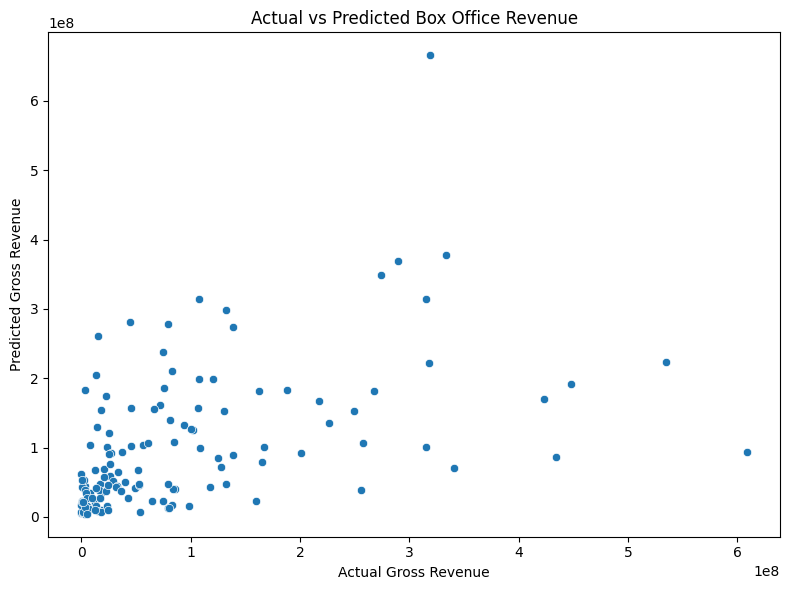

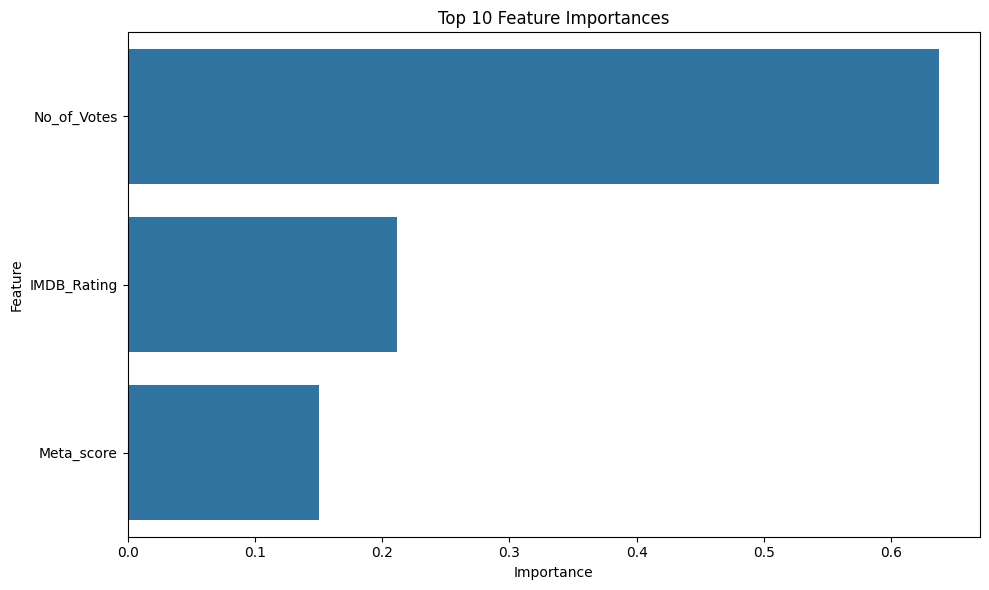


Top 5 Most Incorrect Predictions:
               Title  Actual Gross  Predicted Gross         Error
77     Incredibles 2   608581744.0     9.365392e+07 -5.149278e+08
124      Toy Story 4   434038008.0     8.588923e+07 -3.481488e+08
98          Iron Man   318412101.0     6.657960e+08  3.473839e+08
95   The Dark Knight   534858444.0     2.230776e+08 -3.117808e+08
14          Zootopia   341268248.0     7.030955e+07 -2.709587e+08


C:\Users\jkann\AppData\Local\Temp\ipykernel_10940\840497395.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_mistakes, x='Absolute Error', y='Title', palette="magma")


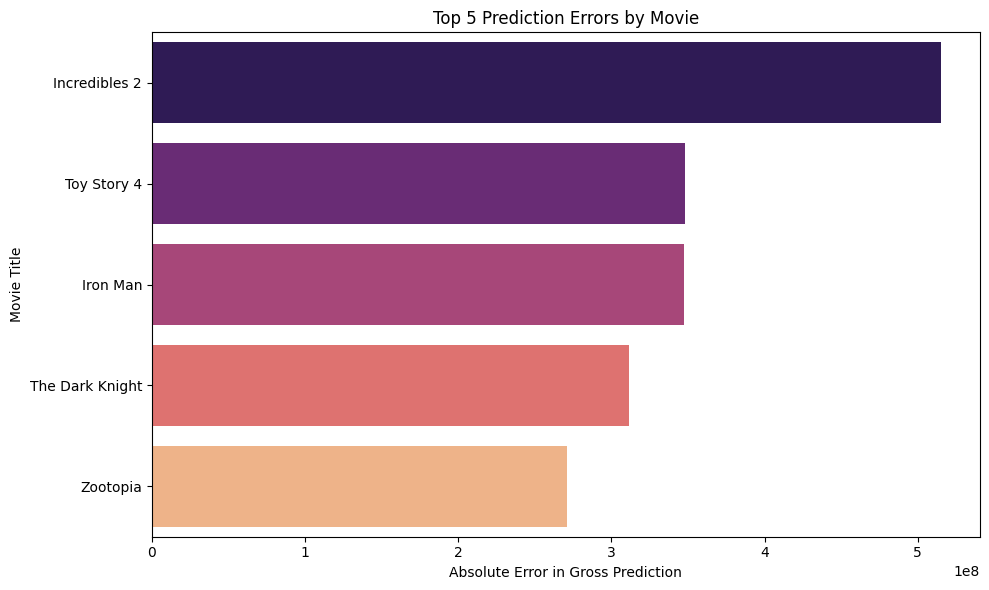

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load dataset
file_path = r"C:\Users\jkann\Downloads\imdb_top_1000.csv"
df = pd.read_csv(file_path, encoding="latin1")

# Clean 'Gross' column: remove symbols and convert to float
df['Gross'] = df['Gross'].replace(r'[\$,]', '', regex=True).replace('', np.nan).astype(float)

# Select relevant features and drop rows with missing data
features = ["Released_Year", "Runtime", "IMDB_Rating", "Meta_score", "No_of_Votes", "Certificate", "Genre"]
target = "Gross"
df_cleaned = df.dropna(subset=features + [target, "Series_Title"]).copy()

# Save titles separately before encoding
titles = df_cleaned['Series_Title'].values  # Preserve title order
df_cleaned = df_cleaned.drop(columns=['Series_Title'])  # Drop before encoding

# Convert categorical columns to category type
categorical_features = ["Certificate", "Genre"]
df_cleaned[categorical_features] = df_cleaned[categorical_features].astype("category")

# One-hot encode categorical columns
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_features, drop_first=True)

# Add titles back after encoding
df_encoded['Series_Title'] = titles

# Define features and target
X = df_encoded.drop(columns=[target, 'Series_Title'])
y = df_encoded[target]
titles_full = df_encoded['Series_Title']

# Train/test split (split titles too)
X_train, X_test, y_train, y_test, titles_train, titles_test = train_test_split(
    X, y, titles_full, test_size=0.2, random_state=42)

# Automatically detect numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['uint8']).columns.tolist()

# Scale numeric columns
scaler = StandardScaler()
X_train_scaled_numeric = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled_numeric = scaler.transform(X_test[numeric_cols])

# Combine scaled numeric and unscaled categorical features
X_train_scaled = np.concatenate([X_train_scaled_numeric, X_train[categorical_cols].values], axis=1)
X_test_scaled = np.concatenate([X_test_scaled_numeric, X_test[categorical_cols].values], axis=1)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict
y_pred = model.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"Mean Squared Error: ${mse:,.2f}")
print(f"R² Score: {r2:.2f}")

# Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Gross Revenue")
plt.ylabel("Predicted Gross Revenue")
plt.title("Actual vs Predicted Box Office Revenue")
plt.tight_layout()
plt.show()

# Feature Importance Plot
importances = model.feature_importances_
feature_names = numeric_cols + categorical_cols
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

# ---------------------------
# Error Analysis - Top 5 Mistakes
# ---------------------------

# Create DataFrame for predictions vs actuals
y_test_reset = y_test.reset_index(drop=True)
titles_test_reset = titles_test.reset_index(drop=True)

results_df = pd.DataFrame({
    'Title': titles_test_reset,
    'Actual Gross': y_test_reset,
    'Predicted Gross': y_pred
})
results_df['Error'] = results_df['Predicted Gross'] - results_df['Actual Gross']
results_df['Absolute Error'] = results_df['Error'].abs()

# Display and plot top 5 errors
top_mistakes = results_df.sort_values(by='Absolute Error', ascending=False).head(5)

print("\nTop 5 Most Incorrect Predictions:")
print(top_mistakes[['Title', 'Actual Gross', 'Predicted Gross', 'Error']])

plt.figure(figsize=(10, 6))
sns.barplot(data=top_mistakes, x='Absolute Error', y='Title', palette="magma")
plt.title('Top 5 Prediction Errors by Movie')
plt.xlabel('Absolute Error in Gross Prediction')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()
